# Examen 3

Para el desarrollo del tercer examen, usar los datos del archivo “Ex_1” para las preguntas del 01 al 03, mientras que para las preguntas 04 al 06 usar el archivo usar el archivo “Ex_2”, mientras que para las preguntas 07 y 08 usar el archivo “Ex_3”. Finalmente, para las preguntas 09 y 10 se va modificar el script del ejercicio de la Sesión 04 del Módulo 06, simular el modelo modificando el umbral de los coeficiente rugosidad, (umbral mínimo 0.06 y umbral máximo 0.08) para las llanuras izquierda y derecha.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio
import geopandas as gpd

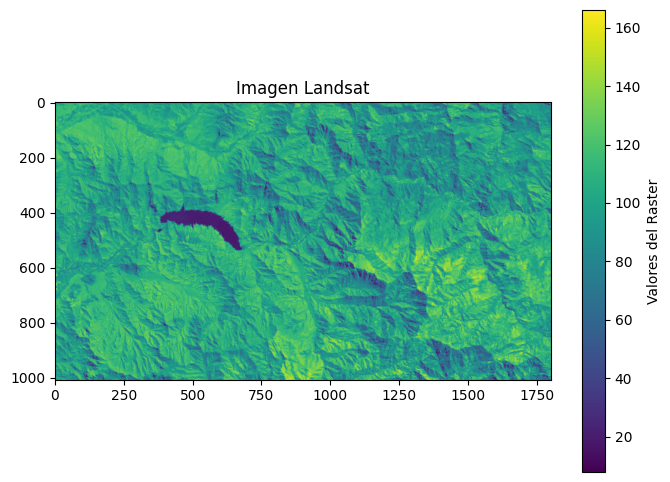

In [3]:
# 1. Obtener una gráfica que muestre el raster con una leyenda que indique el rango de los valores.
img1 = rasterio.open('./Data Examen 3/Ex_1/Rst/landsatImage.tif')
from rasterio import plot

# Leer la primera banda
band1 = img1.read(1)  # Leer la primera banda del raster

# Crear la figura
fig, ax = plt.subplots(figsize=(8,6))

# Mostrar el raster con color 'viridis' y barra de color
img_plot = ax.imshow(band1, cmap="viridis")  # Mostrar la imagen
plt.colorbar(img_plot, ax=ax, label="Valores del Raster")  # Agregar barra de color

# Agregar título
plt.title("Imagen Landsat")

# Mostrar el gráfico
plt.show()


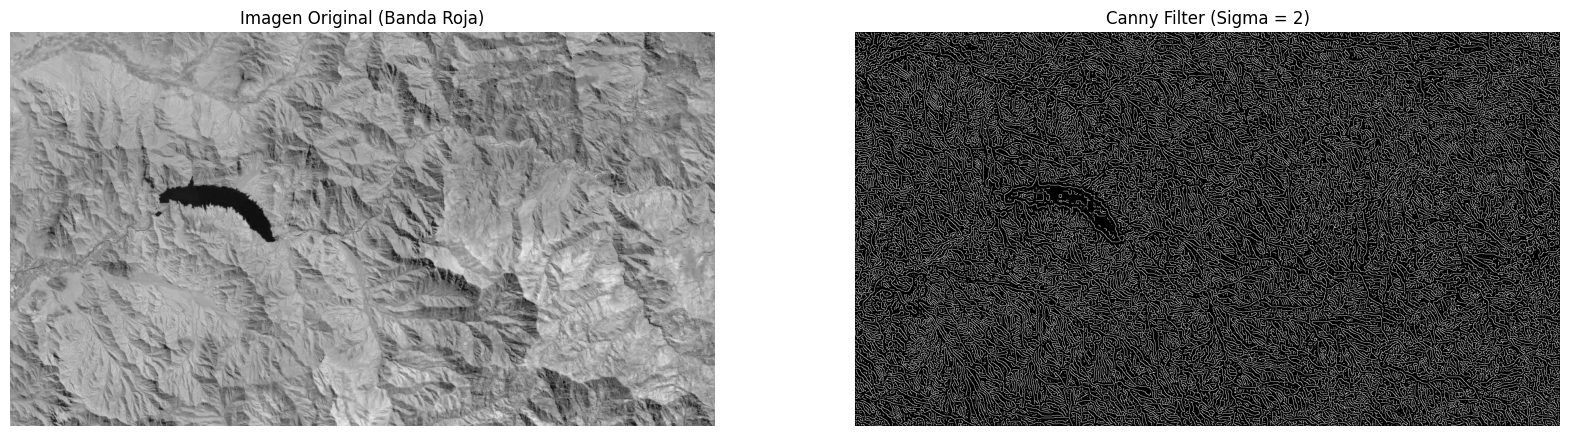

In [4]:
# 2. Obtener gráficas usando Canny filter con 02 valores de sigma.
from skimage import feature
redBand, greenBand, blueBand = img1.read(1), img1.read(2), img1.read(3)
redBand = np.float32(redBand)
greenBand = np.float32(greenBand)
blueBand = np.float32(blueBand)

# Aplicar filtro de Canny con dos valores de sigma
edges_02_sigma = feature.canny(redBand, sigma=2)  # Sigma bajo

# Crear una figura con subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Mostrar imagen original
axes[0].imshow(redBand, cmap=plt.cm.gray)
axes[0].set_title('Imagen Original (Banda Roja)')
axes[0].axis('off')

# Mostrar imagen con Canny (sigma bajo)
axes[1].imshow(edges_02_sigma, cmap=plt.cm.gray)
axes[1].set_title('Canny Filter (Sigma = 2)')
axes[1].axis('off')

plt.show()

Red Band Stats: 8.0 166.0 99.69406


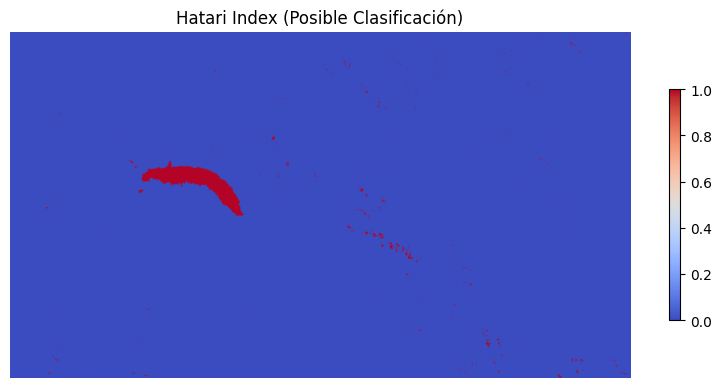

In [5]:
print("Red Band Stats:", np.min(redBand), np.max(redBand), np.mean(redBand))
redFalse = np.zeros(redBand.shape)
redFalse[redBand < 30] = 1

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(redFalse, cmap='coolwarm')  # Mapa de colores para visualización
plt.colorbar(im, shrink=0.5)
plt.title("Hatari Index (Posible Clasificación)")
plt.axis('off')
plt.show()


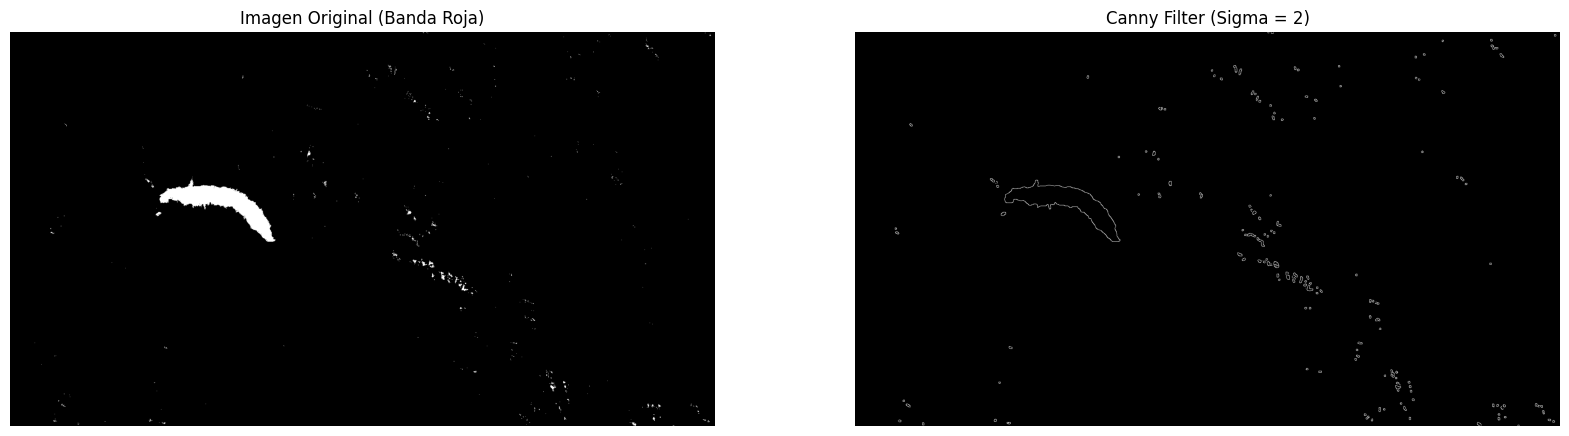

In [6]:
# Aplicar filtro de Canny con dos valores de sigma
edges_02_sigma = feature.canny(redFalse, sigma=2)  # Sigma bajo

# Crear una figura con subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Mostrar imagen original
axes[0].imshow(redFalse, cmap=plt.cm.gray)
axes[0].set_title('Imagen Original (Banda Roja)')
axes[0].axis('off')

# Mostrar imagen con Canny (sigma bajo)
axes[1].imshow(edges_02_sigma, cmap=plt.cm.gray)
axes[1].set_title('Canny Filter (Sigma = 2)')
axes[1].axis('off')

plt.show()

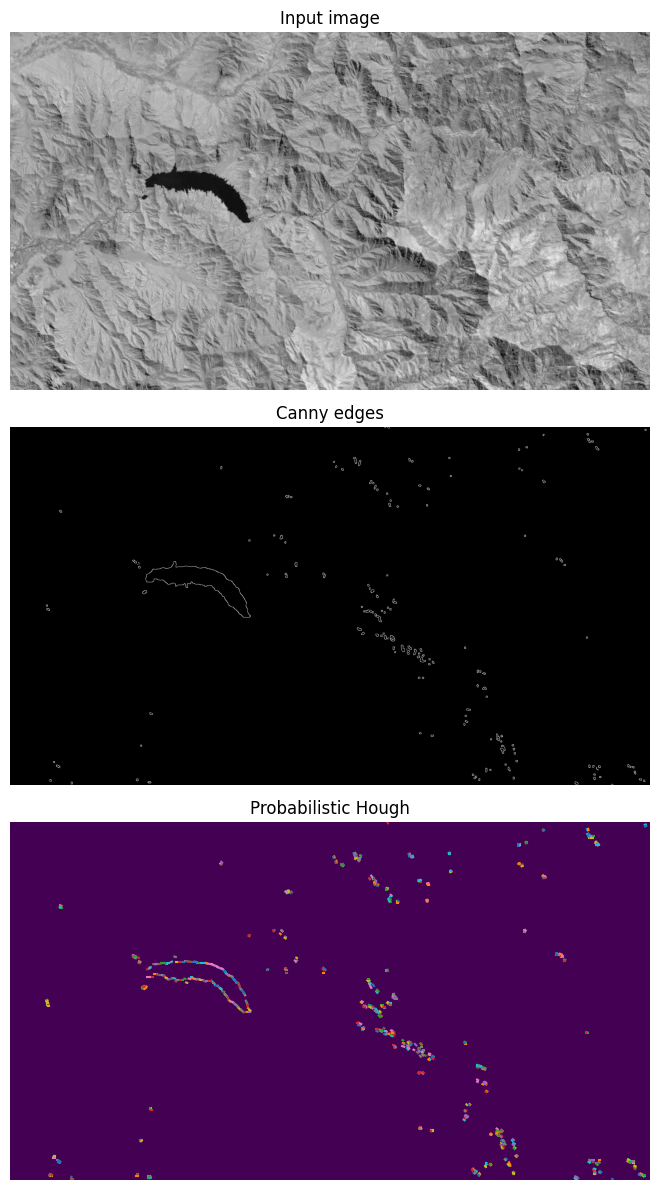

In [7]:
# 3. Obtener una gráfica que muestra la delimitación del cuerpo de agua.
from skimage.transform import probabilistic_hough_line
from matplotlib import cm 
lines = probabilistic_hough_line(edges_02_sigma, threshold=2, line_length=2, line_gap=1)
# Generating figure 2  
fig, axes = plt.subplots(3, 1, figsize=(18, 12), sharex=True,  sharey=True)  
ax = axes.ravel()     
ax[0].imshow(redBand, cmap=cm.gray)  
ax[0].set_title('Input image')     
ax[1].imshow(edges_02_sigma, cmap=cm.gray)  
ax[1].set_title('Canny edges')    
ax[2].imshow(edges_02_sigma * 0)  
for line in lines:      
  p0, p1 = line      
  ax[2].plot((p0[0], p1[0]), (p0[1], p1[1])) 
ax[2].set_xlim((0, redBand.shape[1]))  
ax[2].set_ylim((redBand.shape[0], 0))  
ax[2].set_title('Probabilistic Hough')     
for a in ax:      
  a.set_axis_off()     
plt.tight_layout()
plt.show()  

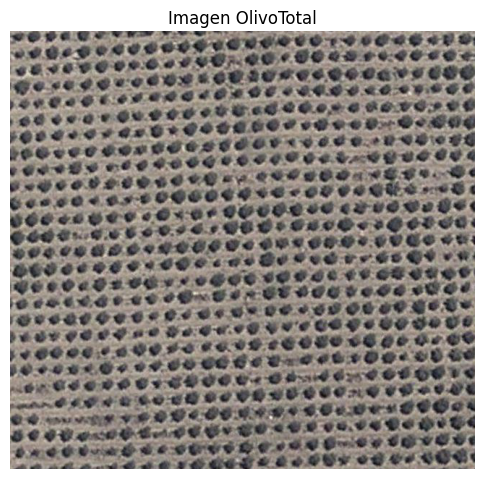

In [ ]:
# 4. Obtener una gráfica de la imagen total (OlivoTotal)..

from PIL import Image
from sklearn.cluster import Birch

# Se carga la imagen con PIL, al no poder usar rasterio por el formato
image_path = './Data Examen 3/Ex_2/OlivoTotal.png'
image = Image.open(image_path)

# Convertir la imagen a un array de numpy
image_array = np.array(image)

# Se grafica la imagen
plt.figure(figsize=(6, 6))
plt.imshow(image_array)
plt.title("Imagen OlivoTotal")
plt.axis("off")
plt.show()


Gray Image Stats: 1 249 120.77359741912265


Text(0.5, 1.0, 'Imagen OlivoTotal en Escala de Grises')

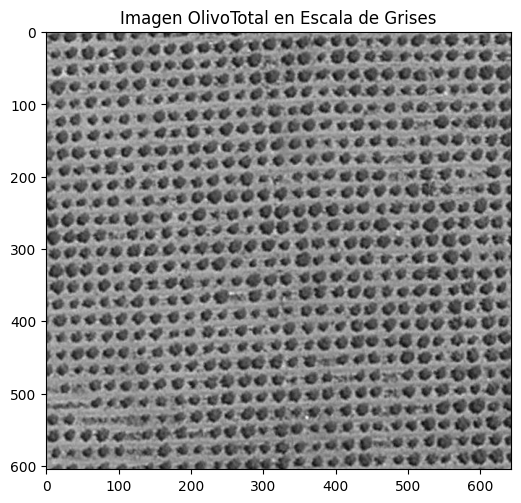

In [ ]:
# 5. Representación mediante una gráfica de los puntos cluster luego de Birch.

# Se convierte la imagen a escala de grises para extraer puntos más fácilmente
gray_image = image.convert("L")
gray_array = np.array(gray_image)

# Se describe los valores medio, maximos y minimos de la imagen
print("Gray Image Stats:", np.min(gray_array), np.max(gray_array), np.mean(gray_array))
plt.figure(figsize=(6, 6))
plt.imshow(gray_array, cmap="gray")
plt.title("Imagen OlivoTotal en Escala de Grises")


In [ ]:
# Se obtienen las coordenadas de los puntos que cumplen con el umbral, 3/4 de la media de la imagen

threshold = np.mean(gray_array) * 0.75
y_coords, x_coords = np.where(gray_array < threshold)
points = np.column_stack((x_coords, y_coords))  # Coordenadas X, Y

# Aplicar clustering Birch
birch = Birch(branching_factor=10000, n_clusters=None, threshold=2e-5, compute_labels=True)
birch.fit(points)
birchPoint = birch.subcluster_centers_


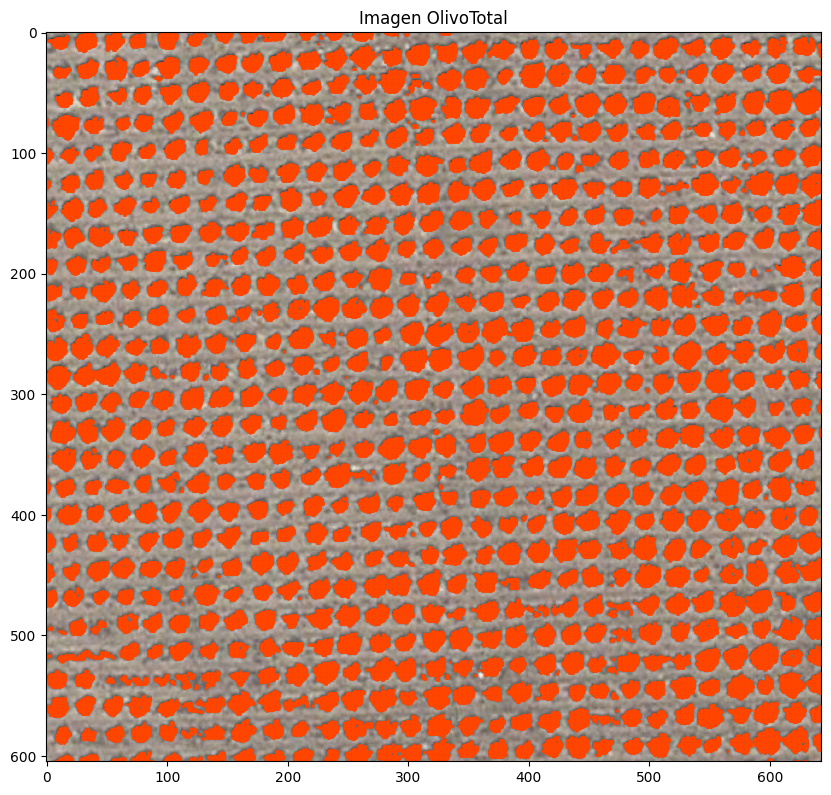

In [23]:
# plot clustered points
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(birchPoint[:,[0]],birchPoint[:,[1]], marker='o',color='orangered',s=1)
plt.imshow(image_array)
plt.title("Imagen OlivoTotal")
plt.show()

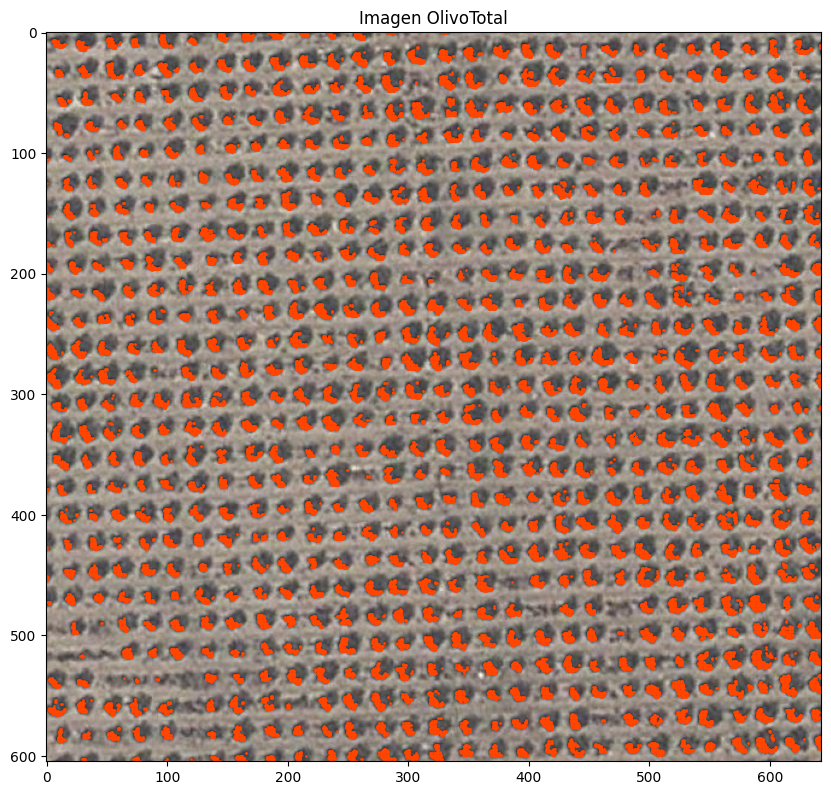

In [27]:
# Intento 2 con la mitad del valor de umbral
threshold = np.mean(gray_array) * 0.5

y_coords, x_coords = np.where(gray_array < threshold)
points = np.column_stack((x_coords, y_coords))  # Coordenadas X, Y

birch = Birch(branching_factor=10000, n_clusters=None, threshold=2e-5, compute_labels=True)
birch.fit(points)
birchPoint = birch.subcluster_centers_
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(birchPoint[:,[0]],birchPoint[:,[1]], marker='o',color='orangered',s=1)
plt.imshow(image_array)
plt.title("Imagen OlivoTotal")
plt.show()

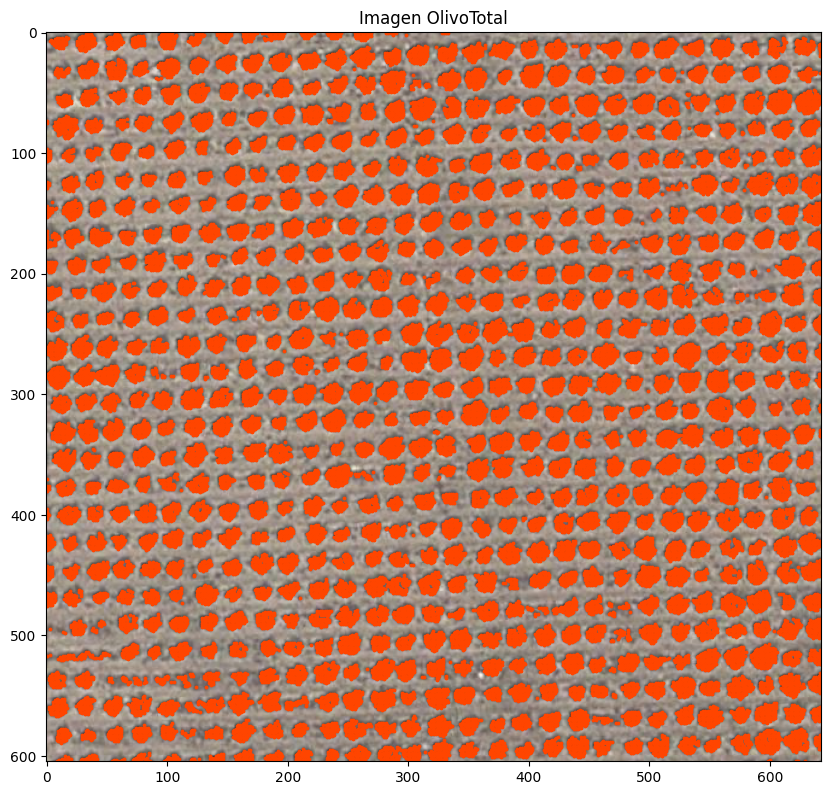

In [33]:
# Intento 3, más arbitrario
threshold = 95

y_coords, x_coords = np.where(gray_array < threshold)
points = np.column_stack((x_coords, y_coords))  # Coordenadas X, Y

birch = Birch(branching_factor=10000, n_clusters=None, threshold=0.8, compute_labels=True)
birch.fit(points)
birchPoint = birch.subcluster_centers_
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(birchPoint[:,[0]],birchPoint[:,[1]], marker='o',color='orangered',s=3)
plt.imshow(image_array)
plt.title("Imagen OlivoTotal")
plt.show()

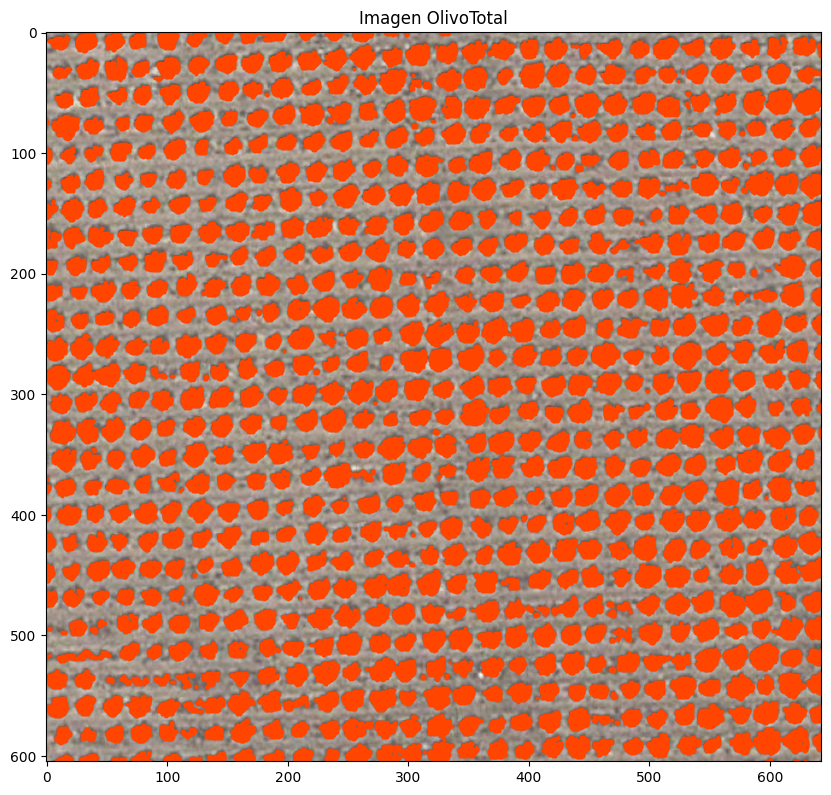

In [ ]:
# Intento 3, más arbitrario
threshold = 95

y_coords, x_coords = np.where(gray_array < threshold)
points = np.column_stack((x_coords, y_coords))  # Coordenadas X, Y

birch = Birch(branching_factor=10000, n_clusters=None, threshold=2e-5, compute_labels=True)
birch.fit(points)
birchPoint = birch.subcluster_centers_
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(birchPoint[:,[0]],birchPoint[:,[1]], marker='o',color='orangered',s=3)
plt.imshow(image_array)
plt.title("Imagen OlivoTotal")
plt.show()

In [ ]:
# 6. Indicar  el número de puntos interpretados.

In [9]:
# 7. Representar mediante una gráfica la evolución de suelo a escala de cuenca durante 100 mil años usando los mismo parámetros de los componentes fluviales, hillslope y uplift del ejercicio desarrollado en la Sesion 02 de Módulo 06.
# 8. Indicar la máxima y mínima elevación del resultado.

In [10]:
# 9. Obtener la gráfica de la superficie del agua.
# 10. Obtener la gráfica de las velocidades.